## 0. Setup

In [1]:
import os
from typing import Dict, Any, List, Literal
from IPython.display import Image, display
from pydantic import BaseModel, Field
import nest_asyncio
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

In [2]:
nest_asyncio.apply()

In [3]:
load_dotenv()

True

In [4]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    base_url="https://openai.vocareum.com/v1",
    api_key=os.getenv("VOCAREUM_API_KEY")
)

## 1. Content-Based Routing

### 1.1. Classifier

In [5]:
class Classification(BaseModel):
    topic: str = Field(
        ...,
        description=(
            "Routing classifier: choose the single best category. "
            "- coding: programming, bug, function, class..."
            "- qa: test, quality, bug, report, testing..."
        ),
        enum=["coding", "qa", "general"]
    )

In [6]:
def classify(text: str) -> str:
    routing_prompt = ChatPromptTemplate.from_template(
        "Extract the desired information from the following passage. "
        "Only extract the properties mentioned in the 'Classification' function. "
        "Passage: \n"
        "{input}"
    )
    classifier = llm.with_structured_output(Classification)
    prompt = routing_prompt.invoke({"input": text})
    response = classifier.invoke(prompt)
    return response.model_dump()

In [7]:
classify("How do I fix this Python bug?")

{'topic': 'coding'}

In [8]:
classify("I need to test for quality assurance")

{'topic': 'qa'}

### 1.2. Specialist Agents

In [9]:
coding_agent = create_react_agent(
    name="coding_agent",
    prompt=SystemMessage(
        content=(
            "You are a coding specialist. " 
            "Help with programming questions. "
            "Concise answers ONLY!"
        )
    ),
    model=llm,
    tools=[],
)

In [10]:
qa_agent = create_react_agent(
    name="qa_agent", 
    prompt=SystemMessage(
        content=(
            "You are a QA specialist. " 
            "Help with testing and quality assurance. "
            "Concise answers ONLY!"
        )
    ),
    model=llm,
    tools=[],
)

In [11]:
general_agent = create_react_agent(
    name="general_agent",
    prompt=SystemMessage(
        content=(
            "You are a general assistant. " 
            "Help with any questions. "
            "Concise answers ONLY!"
        )
    ),
    model=llm,
    tools=[],
)

### 1.3. Workflow

In [12]:
def router(state: MessagesState):
    return classify(state["messages"][-1])["topic"] + "_agent"

In [13]:
workflow = StateGraph(MessagesState)

workflow.add_node("coding_agent", coding_agent)
workflow.add_node("qa_agent", qa_agent) 
workflow.add_node("general_agent", general_agent)

workflow.add_conditional_edges(
    source=START,
    path=router,
    path_map=["coding_agent", "qa_agent", "general_agent"]
)

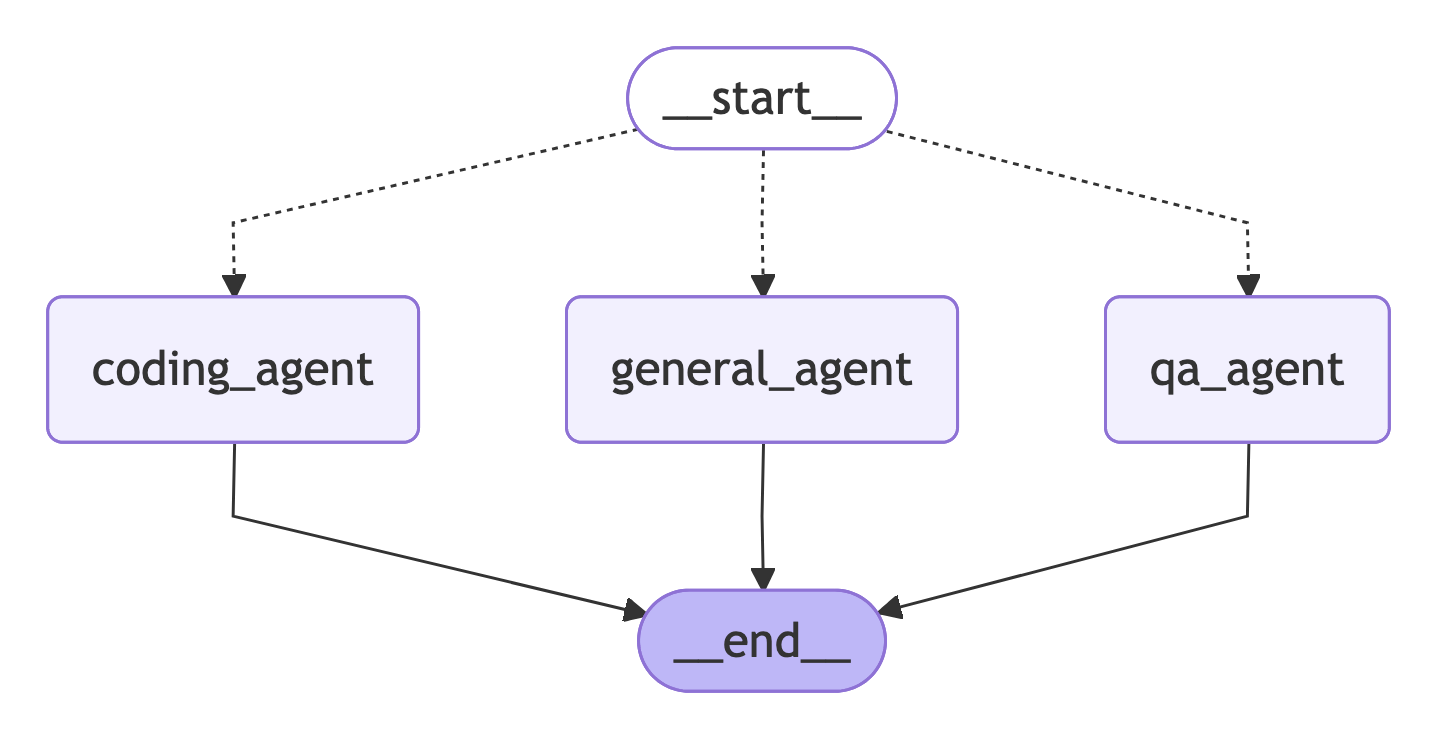

In [14]:
graph = workflow.compile()
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER
        )
    )
)

In [15]:
result = graph.invoke(
    input={
        "messages": [
            HumanMessage(
                content="Need to test my code"
            )
        ]
    }
)

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Need to test my code
================================== Ai Message ==================================
Name: qa_agent

Please provide the code and specify what aspects you want to test (e.g., functionality, performance, security).


In [16]:
result = graph.invoke(
    input={
        "messages": [
            HumanMessage(
                content="What's a class in Java?"
            )
        ]
    }
)

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

What's a class in Java?
================================== Ai Message ==================================
Name: coding_agent

A class in Java is a blueprint for creating objects. It defines properties (attributes) and methods (functions) that the objects created from the class can use. Classes encapsulate data and behavior, promoting code reusability and organization.


In [17]:
result = graph.invoke(
    input={
        "messages": [
            HumanMessage(
                content="What is Postgres?"
            )
        ]
    }
)

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is Postgres?
================================== Ai Message ==================================
Name: general_agent

PostgreSQL, often referred to as Postgres, is an open-source relational database management system (RDBMS) that uses SQL (Structured Query Language) for querying and managing data. It is known for its robustness, extensibility, and support for advanced data types and performance optimization features.


## 2. Round-Robin Routing

In [18]:
class RoundRobinState(MessagesState):
    """State that tracks which agent to call next."""
    agent_names: List[str]
    current_agent_index: int

In [19]:
agent_pool:List[CompiledStateGraph] = [
    create_react_agent(
        name=f"worker_{i}",
        prompt=SystemMessage(
            content=(
                "ALWAYS Reply with: "
                f"[Worker Agent {i}] Task '<tast_name>' processed!"
                "-- Fill <tast_name> with the task assigned to you"
            )
        ),
        model=llm,
        tools=[],
    ) for i in range(1, 4)
]

In [20]:
def update_index(state: RoundRobinState):
    agent_names = state["agent_names"]
    current_agent_index = state.get("current_agent_index", 0)
    new_agent_index = current_agent_index + 1  
    new_agent_index_in_range = new_agent_index % len(agent_names)
    return {
        "current_agent_index": new_agent_index_in_range
    }

In [21]:
def route_round_robin(state: RoundRobinState):
    """Route tasks in round-robin fashion."""
    agent_names = state["agent_names"]
    current_agent_index = state.get("current_agent_index", 0)
    current_agent_index_in_range = current_agent_index % len(agent_names)

    return agent_names[current_agent_index_in_range]

In [22]:
agent_names = [agent.name for agent in agent_pool]

In [23]:
agent_names

['worker_1', 'worker_2', 'worker_3']

In [24]:
workflow = StateGraph(RoundRobinState)

workflow.add_node("update_index", update_index)
for i, agent in enumerate(agent_pool, 1):
    workflow.add_node(f"worker_{i}", agent)

workflow.add_edge(START, "update_index")

workflow.add_conditional_edges(
    source="update_index",
    path=route_round_robin,
    path_map=agent_names
)

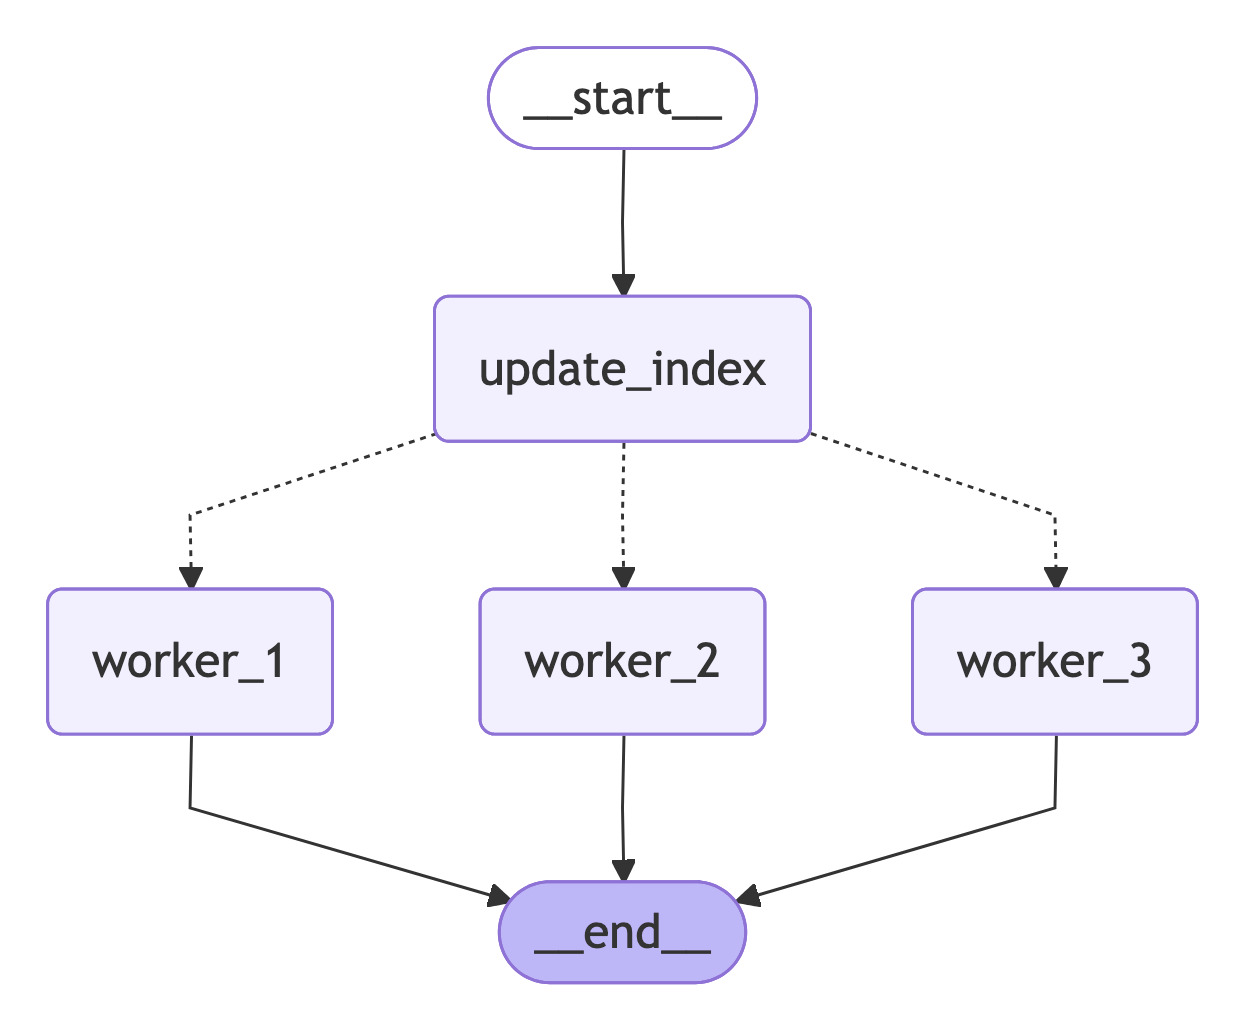

In [25]:
graph = workflow.compile(checkpointer=MemorySaver())
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER
        )
    )
)

In [26]:
def run_round_robin():
    result = graph.invoke(
        input={
            "agent_names": agent_names,
            "messages": [
                HumanMessage(
                    content="New issue assigned to you"
                )
            ]
        }, 
        config={
            "configurable": {
                "thread_id": "1"
            }
        }
    )
    return result

In [27]:
for _ in range(5):
    result = run_round_robin()
    print(result['messages'][-1].content)
    print("current_agent_index", result['current_agent_index'])
    print("\n")

[Worker Agent 2] Task 'New issue assigned to you' processed!
current_agent_index 1


[Worker Agent 3] Task 'New issue assigned to you' processed!
current_agent_index 2


[Worker Agent 1] Task 'New issue assigned to you' processed!
current_agent_index 0


[Worker Agent 2] Task 'New issue assigned to you' processed!
current_agent_index 1


[Worker Agent 3] Task 'New issue assigned to you' processed!
current_agent_index 2




## 3. Priority-Based Routing

In [28]:
class UrgencyClassification(BaseModel):
    urgency: str = Field(
        ...,
        description=(
            "Urgency classifier: determine the priority level of the message. "
            "- urgent: critical, emergency, asap, immediate, fire, security breach... "
            "- normal: routine, general, standard, regular..."
        ),
        enum=["urgent", "normal"]
    )

In [29]:
def classify_urgency(text: str) -> str:
    urgency_prompt = ChatPromptTemplate.from_template(
        "Extract the desired information from the following passage. "
        "Only extract the properties mentioned in the 'UrgencyClassification' function. "
        "Passage: \n"
        "{input}"
    )
    urgency_classifier = llm.with_structured_output(UrgencyClassification)
    prompt = urgency_prompt.invoke({"input": text})
    response = urgency_classifier.invoke(prompt)
    return response.model_dump()

In [30]:
classify_urgency("This is an urgent security issue that needs immediate attention")

{'urgency': 'urgent'}

In [31]:
urgent_agent = create_react_agent(
    name="urgent_agent",
    prompt=SystemMessage(
        content=(
            "You are an urgent task specialist. "
            "Handle critical issues immediately with high priority. "
            "ALWAYS start your response with '[URGENT]' and be concise!"
        )
    ),
    model=llm,
    tools=[],
)

In [32]:
normal_agent = create_react_agent(
    name="normal_agent",
    prompt=SystemMessage(
        content=(
            "You are a normal task specialist. "
            "Handle routine tasks efficiently. "
            "ALWAYS start your response with '[NORMAL]' and be helpful!"
        )
    ),
    model=llm,
    tools=[],
)

In [33]:
def route_by_priority(state: MessagesState) -> Literal["urgent_agent", "normal_agent"]:
    """Route based on message urgency classification."""
    classification = classify_urgency(state["messages"][-1].content)
    return classification["urgency"] + "_agent"


In [34]:
priority_workflow = StateGraph(MessagesState)

priority_workflow.add_node("urgent_agent", urgent_agent)
priority_workflow.add_node("normal_agent", normal_agent)

priority_workflow.add_conditional_edges(
    source=START,
    path=route_by_priority,
    path_map=["urgent_agent", "normal_agent"]
)


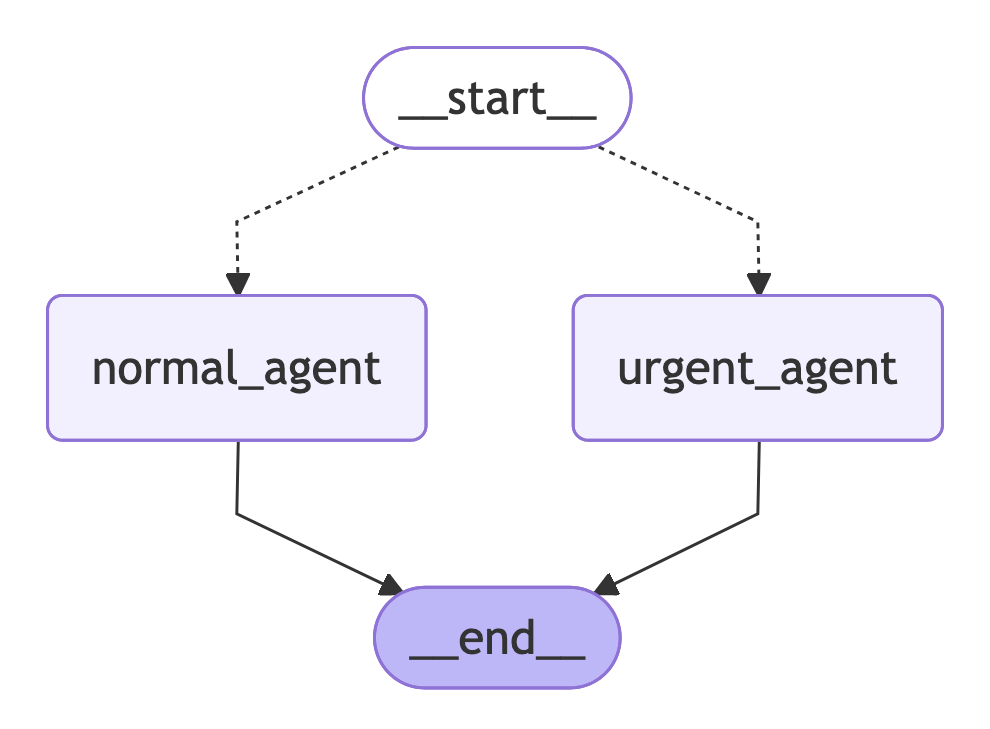

In [35]:
graph = priority_workflow.compile()
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER
        )
    )
)

In [36]:
result = graph.invoke({
    "messages": [
        HumanMessage(
            content="Just a routine question about the system"
        )
    ]
})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Just a routine question about the system
================================== Ai Message ==================================
Name: normal_agent

[NORMAL] Of course! Please go ahead and ask your routine question about the system, and I'll do my best to assist you.


In [37]:
result = graph.invoke({
    "messages": [
        HumanMessage(
            content="ASAP: Database connection failed, production is down!"
        )
    ]
})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

ASAP: Database connection failed, production is down!
================================== Ai Message ==================================
Name: urgent_agent

[URGENT] Check the following immediately:

1. **Database Server Status**: Ensure the database server is running.
2. **Connection Strings**: Verify the connection strings in your application configuration.
3. **Network Issues**: Check for any network connectivity problems between the application and the database.
4. **Logs**: Review application and database logs for error messages.
5. **Resource Limits**: Ensure the database is not hitting resource limits (CPU, memory, connections).

Resolve these issues to restore the connection.
